# Transfer learning with TensorFlow


Create a headless mobilenet model (without classification layer). Then add classification layer and retrain that layer to recognize the classes in our dataset.

## Setup

In [1]:
import numpy as np
import os
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub


In [2]:
#Hyperparameters
IMAGE_SIDE = 128
INPUT_SHAPE = (IMAGE_SIDE, IMAGE_SIDE, 3)
IMAGE_SHAPE = (IMAGE_SIDE, IMAGE_SIDE)
ALPHA = 0.25
MOBILENET_V = 1

# Training Parameters
NUM_EPOCHS = 4
DROPOUT_RATE = 0.2
VALIDATION_SPLIT = 0.2
VERBOSE = 1

alpha_string = str(ALPHA).replace('.','')
model_name = "mobilenet_v{}_{}_{}".format(MOBILENET_V, alpha_string, IMAGE_SIDE)


### Dataset

Use a local datashet with pictures of things that are hotdogs and not hotdogs.

In [3]:
# use dataroute to hotdogs
train_data_dir = "./training_and_validation_images"

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=VALIDATION_SPLIT) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=batch_size,
    #class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=IMAGE_SHAPE,
    batch_size=batch_size,
    #class_mode='binary',
    subset='validation') # set as validation data

Found 3180 images belonging to 2 classes.
Found 794 images belonging to 2 classes.


In [5]:
num_train_images = len(train_generator.filenames)
num_validation_images = len(validation_generator.filenames)

The resulting object is an iterator that returns `image_batch, label_batch` pairs.

###  Add classifier to headless model (CNN frontend) and do transfer learning


Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [6]:
if MOBILENET_V==1:
    from tensorflow.keras.applications import MobileNet as mobnet
elif MOBILENET_V==2:
    from tensorflow.keras.applications import MobileNetV2 as mobnet
else:
    print("Unsupported Mobilenet version {}".format(MOBILENET_V)) 

#from tensorflow.keras import layers, initializers
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# create the various parts of the model
headless_model = mobnet(
    alpha=ALPHA, 
    include_top = False,
    input_shape=INPUT_SHAPE, 
    weights='imagenet',
)
# Convolutional frontend stays fixed during transfer learning
headless_model.trainable = False 

### Attach a classification head

Add classification layer to the headless model using the functional API 

In [7]:
from tensorflow.keras import regularizers

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# New classifier to be trained with Transfer Learning
classifier = tf.keras.layers.Dense(2)

# Assemble the model using functional API
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = headless_model(inputs)
x = global_average_layer(x)    
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = classifier(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

# Store for later
regularization = "Dropout {}".format(DROPOUT_RATE)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 219,058
Trainable params: 514
Non-trainable params: 218,544
_________________________________________________________________


### Train the model

Use compile to configure the training process:

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 219,058
Trainable params: 514
Non-trainable params: 218,544
_________________________________________________________________


Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [9]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

In [10]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
batch_stats_callback = CollectBatchStats()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs = NUM_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    verbose=VERBOSE,
    callbacks=[batch_stats_callback]
)

Epoch 1/4
100/100 [==============================] - 50s 502ms/step - loss: 0.1579 - accuracy: 0.9375 - val_loss: 0.1284 - val_accuracy: 0.9534
Epoch 2/4
100/100 [==============================] - 36s 360ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9685
Epoch 3/4
100/100 [==============================] - 48s 481ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9773
Epoch 4/4
100/100 [==============================] - 35s 348ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9761


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

In [11]:
# Get training and validation accuracy from the last epoch (-1)
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

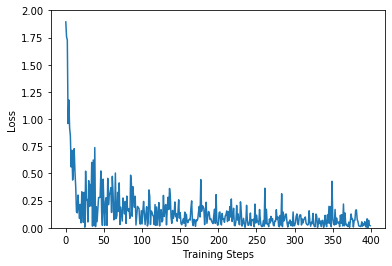

In [12]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

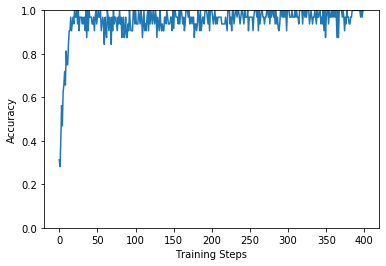

In [13]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## Export your model

Now that you've trained the model, export it as a SavedModel for use later on.

In [14]:
timestamp = time.time()

export_path = "./saved_models/retrained_{}_{}".format(model_name, int(timestamp))
model.save(export_path)

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_models/retrained_mobilenet_v1_025_128_1607360710/assets


'./saved_models/retrained_mobilenet_v1_025_128_1607360710'

Now confirm that we can reload it, and it still gives the same results:

## Load the model

In [15]:
import_path = export_path
#Note: if you want to reload a different model override import_path here
#import_path = "./retrained_mobilenet/1605036162"
reloaded_model = tf.keras.models.load_model(import_path)

In [16]:
image_batch = validation_generator.next()
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [17]:
abs(reloaded_result_batch - result_batch).max()

0.0

This SavedModel can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).


   ## Evaluate the model 

In [18]:
# Get test data with image_dataset_from_directory
# get test data with ImageDataGenerator
test_data = "./test_images"
test_datagen = ImageDataGenerator(rescale=1./255) # set validation split
test_generator = test_datagen.flow_from_directory(str(test_data), target_size=IMAGE_SHAPE)
num_test_images = len(test_generator.filenames)

Found 32 images belonging to 2 classes.


In [19]:
# evaluate with the test_generator
test_loss, test_acc = reloaded_model.evaluate(test_generator, verbose=VERBOSE)
#print("test loss: {}, test accuracy {}".format(test_loss, test_acc))

1/1 [==============================] - 0s 1ms/step - loss: 0.3181 - accuracy: 0.9062


In [20]:
PREDICT_ALL_IMAGES_WORKS = 0
if PREDICT_ALL_IMAGES_WORKS:
    predictions = reloaded_model.predict(validation_generator)
    #print(validation_generator.classes)
    validation_generator.shuffle = True
    validation_generator.batch_size = 1
    validation_generator.reset()
    
    fnames = validation_generator.filenames ## fnames is all the filenames/samples used in testing
    num_files = len(fnames)
    
    pred_classes = reloaded_model.predict_generator(validation_generator, steps=num_files)
    pred_classes = predictions.argmax(axis=-1)
    
    print(validation_generator.class_indices)
    
    fnames_generated = []
    validation_generator.reset()
    gen = validation_generator
    for i, images in enumerate(gen):
        #print(i)
        idx = (gen.batch_index - 1) * gen.batch_size
        #print(gen.filenames[idx : idx + gen.batch_size])
        fnames_generated.append(gen.filenames[idx : idx + gen.batch_size])
        if(i>=num_files):
            break
            
    print(pred_classes.size)
    
    file_sequence_errors = np.where(fnames_generated != fnames)[0]
    print(file_sequence_errors.size)
    # Very strange !!! The file sequence is the same in filenames and what the DirectoryIterator 
    # Despite this The Predictions contain 68 mismatches.
    # When the Prediction is tested using the check_predictions method below there are only 6 mimatches
    
    errors = np.where(pred_classes != validation_generator.classes)[0] ## misclassifications done on the test data where y_pred is the predicted values
    print(errors.size)
    #for i in errors:
        #print(fnames[i])

## Check Predictions

In [21]:
# add first dimension for batch
INPUT_BATCH_SHAPE = (1,)+INPUT_SHAPE

def check_predictions(model, image_generator):
    #Test the model and store incorrect predictions
    image_generator.reset()
    incorrect_predictions = []
    pred_count=0
    classes = [*image_generator.class_indices] # unpack keys into array
    print(classes)
    num_images = len(image_generator.filenames)
    print("checking Predictions of {} test images".format(num_images))
    # Get predictions for a batch of images
    for image_batch, label_batch in image_generator:
        for i, image in enumerate(image_batch):
            batch_image = tf.reshape(image, INPUT_BATCH_SHAPE)
            prediction = model.predict(batch_image)
            label_idx = tf.argmax(label_batch[i])
            pred_idx = tf.argmax(prediction[0])
            if(label_idx != pred_idx):
                print("Error: label: "+classes[label_idx]+", prediction: "+classes[pred_idx])
                rec = {}
                rec['gt'] = classes[label_idx]
                rec['pred'] = classes[pred_idx]
                rec['image'] = image
                incorrect_predictions.append(rec)
            #example["float_summary"] = f"float model: {top1[0]}, {top1[1]:.2%}"
            pred_count+=1
            if pred_count >= num_images:
              break
        else:
            continue
        break
    nip = len(incorrect_predictions)
    np = num_images
    print("{} incorrect predictions for {} images. Accuracy {}%".format(nip, np, 100*(np-nip)/np))
    return incorrect_predictions

In [22]:
def plot_incorrect_predictions(incorrect_predictions):
    plt.figure(figsize=(20, 5*int((len(incorrect_predictions)+4)/5)))
    print("Incorrectly predicted images:")
    for i, rec in enumerate(incorrect_predictions):
        plt.subplot(int((len(incorrect_predictions)+5)/5), 5, i + 1)
        #image = tf.reshape(rec['image'],(224,224,3))
        #print(rec['image'])
        plt.imshow(tf.image.convert_image_dtype(rec['image'], tf.uint8))
        plt.title("ground truth: " + rec['gt'])
        plt.title('\n'.join(["ground truth: " + rec['gt'],'prediction:'  + rec['pred']]))
        plt.axis("off")

In [23]:
# Check predictions on validation_generator
incorrect_predictions = check_predictions(reloaded_model, test_generator)

['hotdogs', 'not_hotdogs']
checking Predictions of 32 test images
Error: label: hotdogs, prediction: not_hotdogs
Error: label: hotdogs, prediction: not_hotdogs
Error: label: not_hotdogs, prediction: hotdogs
3 incorrect predictions for 32 images. Accuracy 90.625%


Incorrectly predicted images:


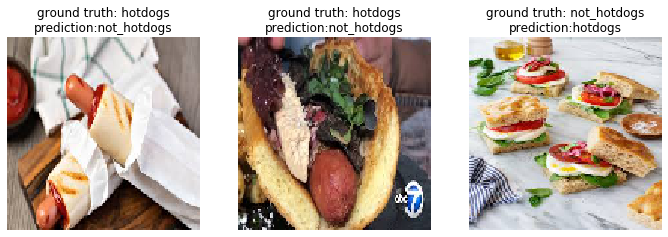

In [24]:
plot_incorrect_predictions(incorrect_predictions)

In [25]:
# Can we trust this given the issue with the validation_generator described above?
predictions = reloaded_model.predict(test_generator)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_generator.classes, predictions.argmax(axis=-1)))

[[ 2  7]
 [ 6 17]]


## Add the hyperparameters and accuracy data to the spreadsheet

In [27]:
def update_xlsx_file(xlsx_file, df):
    import pandas as pd
    # Create or update the xlsx_file
    writer = pd.ExcelWriter(xlsx_file, engine='openpyxl')
    
    if(os.path.exists(xlsx_file)):
        # try to open an existing workbook
        print("Appending to existing file {}".format(xlsx_file))
        header = False
        writer.book = load_workbook(xlsx_file)
    else:
        print("Creating new file {}".format(xlsx_file))
        header = True
    # copy existing sheets
    writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
    num_rows = 0
    if(os.path.exists(xlsx_file)):
        # read existing file
        reader = pd.read_excel(r'{}'.format(xlsx_file))
        num_rows = len(reader)
    # write out the new sheet
    df.to_excel(writer,index=False,header=header,startrow=num_rows+1)
    
    writer.close()

In [28]:
import pandas as pd
from openpyxl import load_workbook

xlsx_file = 'hyperparameter_tuning_autogen.xlsx'
   
# new dataframe with same columns
df = pd.DataFrame(
                  {'net_name': ["mobilenet_v{}".format(MOBILENET_V)],
                   'alpha': [ALPHA],
                   'num params' : [reloaded_model.count_params()],
                   'input shape': [str(INPUT_SHAPE)],
                   'num epochs': [NUM_EPOCHS],
                   'regularization': [regularization],
                   'training accuracy' : [train_accuracy],
                   'validation accuracy' : [val_accuracy],
                   'test accuracy' : [test_acc],
                   'training images' : [num_train_images],
                   'validation images' : [num_validation_images],
                   'test images' : [num_test_images],
                   'timestamp' : [timestamp],
                  }
                 )

update_xlsx_file(xlsx_file, df)


Appending to existing file hyperparameter_tuning_autogen.xlsx
